In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
# Our so-called "masterlist" - a merge of CTCF and RAD21 peaks - as a collection of
# biologically relevant sites to look at ...
feat_names = OrderedDict()
feat_names["rad_ctcf_union"] = "allTSS_wstrand.bed"

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [5]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end","strand"],
        usecols=(0,1,2,3),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)


### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


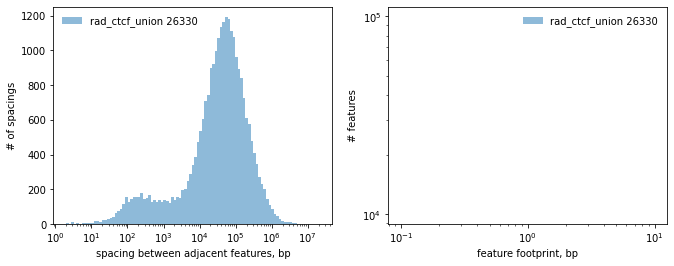

In [6]:
plot_spacing_footprint_distros(dfs)

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [7]:
#let's describe our samples that we want to have in Figure 1 ...
supfig1L_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","h3k4_r1","mrna_ctcf"]
titles = supfig1L_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in supfig1L_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [8]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks(bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features rad_ctcf_union:(26330) ...


stacking up ctcf ...
CPU times: user 3.48 s, sys: 152 ms, total: 3.63 s
Wall time: 3.62 s
stacking up noctcf ...
CPU times: user 3.36 s, sys: 123 ms, total: 3.48 s
Wall time: 3.47 s
stacking up rad21_CTCF ...
CPU times: user 3.79 s, sys: 123 ms, total: 3.92 s
Wall time: 3.91 s
stacking up rad21_noCTCF ...
CPU times: user 3.02 s, sys: 160 ms, total: 3.18 s
Wall time: 3.17 s
stacking up ins_CTCF ...
CPU times: user 2.68 s, sys: 128 ms, total: 2.81 s
Wall time: 2.8 s
stacking up ins_noCTCF ...
CPU times: user 2.79 s, sys: 84.4 ms, total: 2.88 s
Wall time: 2.87 s
stacking up h3k4_r1 ...
CPU times: user 4.42 s, sys: 128 ms, total: 4.55 s
Wall time: 4.53 s
stacking up mrna_ctcf ...
CPU times: user 2.56 s, sys: 200 ms, total: 2.76 s
Wall time: 2.75 s


In [9]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "gene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "gene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
supfig1L_samples.append(feat_name)
titles = supfig1L_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

# try to discriminate overlaping genes with the lack of genes  - white/gray  - fill missing nan ....

stacking genes up for rad_ctcf_union ...


### Re-orient stackups according to the gene orientation

In [10]:
flip_stackup_dict = OrderedDict()
for k in dfs:
    # flippin separately for each set ...
    print(f"preparing to flip {k} ...")
    the_stackup = stackup_dict[k]
    # we'll be flipping according to gene orientation ....
    the_strand = dfs[k]["strand"]
    preflip_index = the_strand.index

    # flipped index according to EV1
    flip_stackup_index = np.concatenate([
        preflip_index[the_strand=="+"],
        preflip_index[the_strand=="-"],
        preflip_index[pd.isna(the_strand)] # don't forget to bring NaN-filled EVs back in
    ])
    
    assert (np.sort(flip_stackup_index) == preflip_index).all()

    # flip EVERYTHING according to the strand
    flip_stackups = {}
    for s in bw_fnames:
        flip_stackups[s] = np.concatenate([
            the_stackup[s][the_strand=="+"],
            (-1 if s=="gene" else 1) * the_stackup[s][the_strand=="-"][:,::-1],
            the_stackup[s][pd.isna(the_strand)] # keep NaN-filled items along unperturbed
        ])[np.argsort(flip_stackup_index)]
    # !!! Make sure rows in the stackups are re-sorted back the same way
    # ro ensure they are in sync with the input BED-files !
        
    # print flip condition numbers ...
    sum_p = (the_strand=="+").sum()
    sum_m = (the_strand=="-").sum()
    sum_n = pd.isna(the_strand).sum()

    print(f"initial number of items {len(the_strand)}, intact {sum_p}, flipped {sum_m} , NaN-filled {sum_n}")
    print(f"{sum_p} + {sum_m} + {sum_n} = {sum_p+sum_m+sum_n}")
    
    # save flipped the_stackup to the new OrderedDict ...
    flip_stackup_dict[k] = flip_stackups


preparing to flip rad_ctcf_union ...
initial number of items 26330, intact 13377, flipped 12953 , NaN-filled 0
13377 + 12953 + 0 = 26330


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [11]:
# this is done INPLACE - be carefull !
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

for feature_key in flip_stackup_dict:
    the_stackup = flip_stackup_dict[feature_key]
    # define the size of the shoulder - flank size
    l, w = the_stackup["ins_CTCF"].shape
    norm_flank = int(w*0.25)

    normalize_insulation_stackups_INPLACE(
        the_stackup,
        insulation_keys,
        subtract = "shoulders",
        subtract_size = norm_flank,
    )

In [12]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.25,0.02)
    cmps[s] = cmapYlGnBu_r

### starting with some sorting, keeping legacy sorting approaches for now

In [13]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in flip_stackup_dict:
    the_stackups = flip_stackup_dict[feature_key]
    length,width = the_stackups['h3k4_r1'].shape
    center_bin = int(width/2)
    # h3k4_r1 is a narrow signal - so sorting on 2 bins around cener should be ok ...
    the_stackups['K4_mean'] = np.nanmean(the_stackups['h3k4_r1'][:,center_bin-3:center_bin+3],axis=1)
    _, _jjj = recursive_data_ordering(
                ks = [('K4_mean', "sort", 1, False)],
                idxs = np.arange( length ),
                data_dict = the_stackups,
                verbose=True,
    )
    reordered_jdxs[feature_key] = _jjj



sorting 26330 elements of K4_mean into 1 groups ...


### let's perform a scientific selection of the number of active TSS - as a "place" where K4_mean signal drops from to None ...

this can be done by averaging K4 over different number of bins around TSS - we concluded that -1,+1 (2 bins-wide) is too narrow, and +/-3 and +/-2 are very similar, "reliable" and smooth - and we chose +/-3 (6-200bp bins wide) for the downstream analysis ...

#### plotting those running averages is integrated into `plot_stackups` function ...

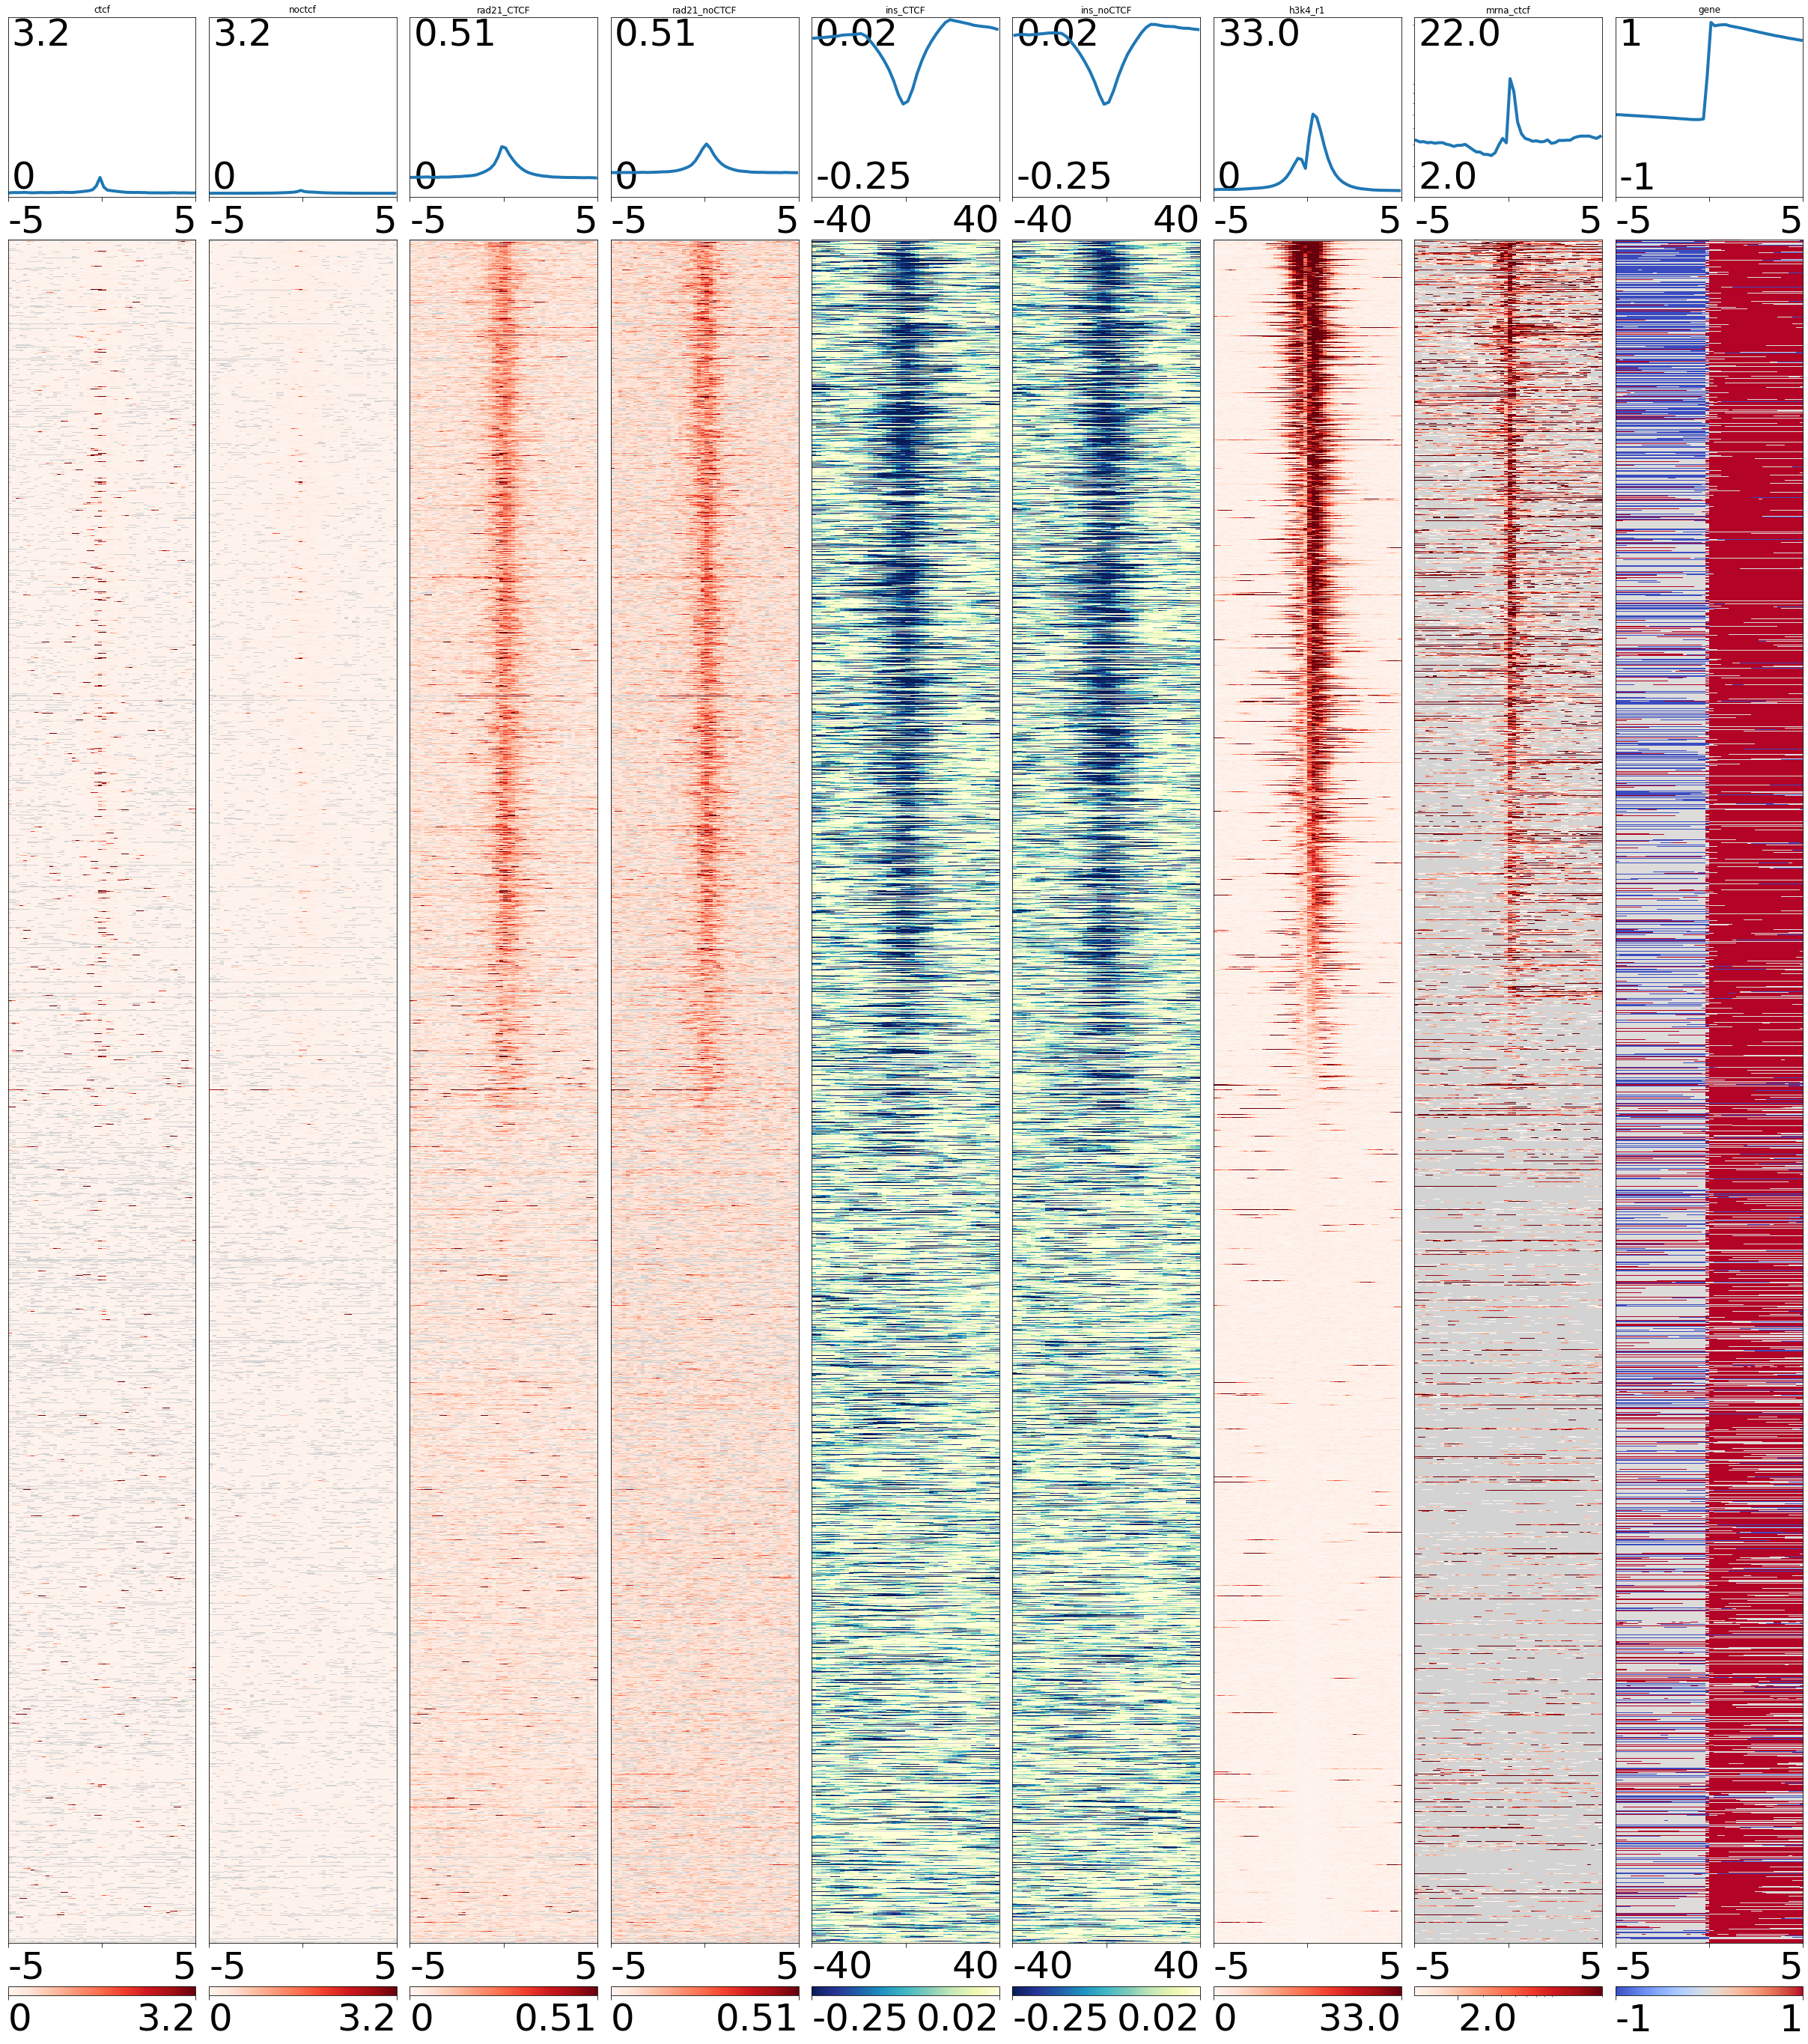

In [14]:
hmss = OrderedDict()

for feature_key in flip_stackup_dict:
    jjj = reordered_jdxs[feature_key]
    _stackups = flip_stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in supfig1L_samples ]

_limss = [ limss[_k] for _k in supfig1L_samples ]
_cmps = [ cmps[_k] for _k in supfig1L_samples ]
_binsizes = [ binsizes[_k] for _k in supfig1L_samples ]
_norms = [ norms[_k] for _k in supfig1L_samples ]

extra_order = None
hmss_order = None#[0,1,2,3,4,5,6,9,8,10,11,12,7]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

# plt.savefig("Fig1_masterlist_all.pdf")

### let's plot active TSSs only ...

let's define them first by looking at the sorted values of the `K4_mean` signal ...

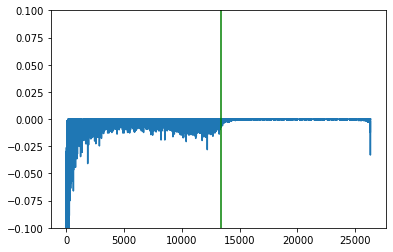

In [15]:
plt.plot(np.diff(the_stackups['K4_mean'][jjj]))
# print(np.diff(stackups['K4_mean'][jjj])[5000:17000].argmin())
ax = plt.gca()
ax.set_ylim(-0.1,0.1)
ax.axvline(12312+1100,color="green")
number_of_active_TSS = 13412

sorting 13412 elements of rad21_mean into 1 groups ...


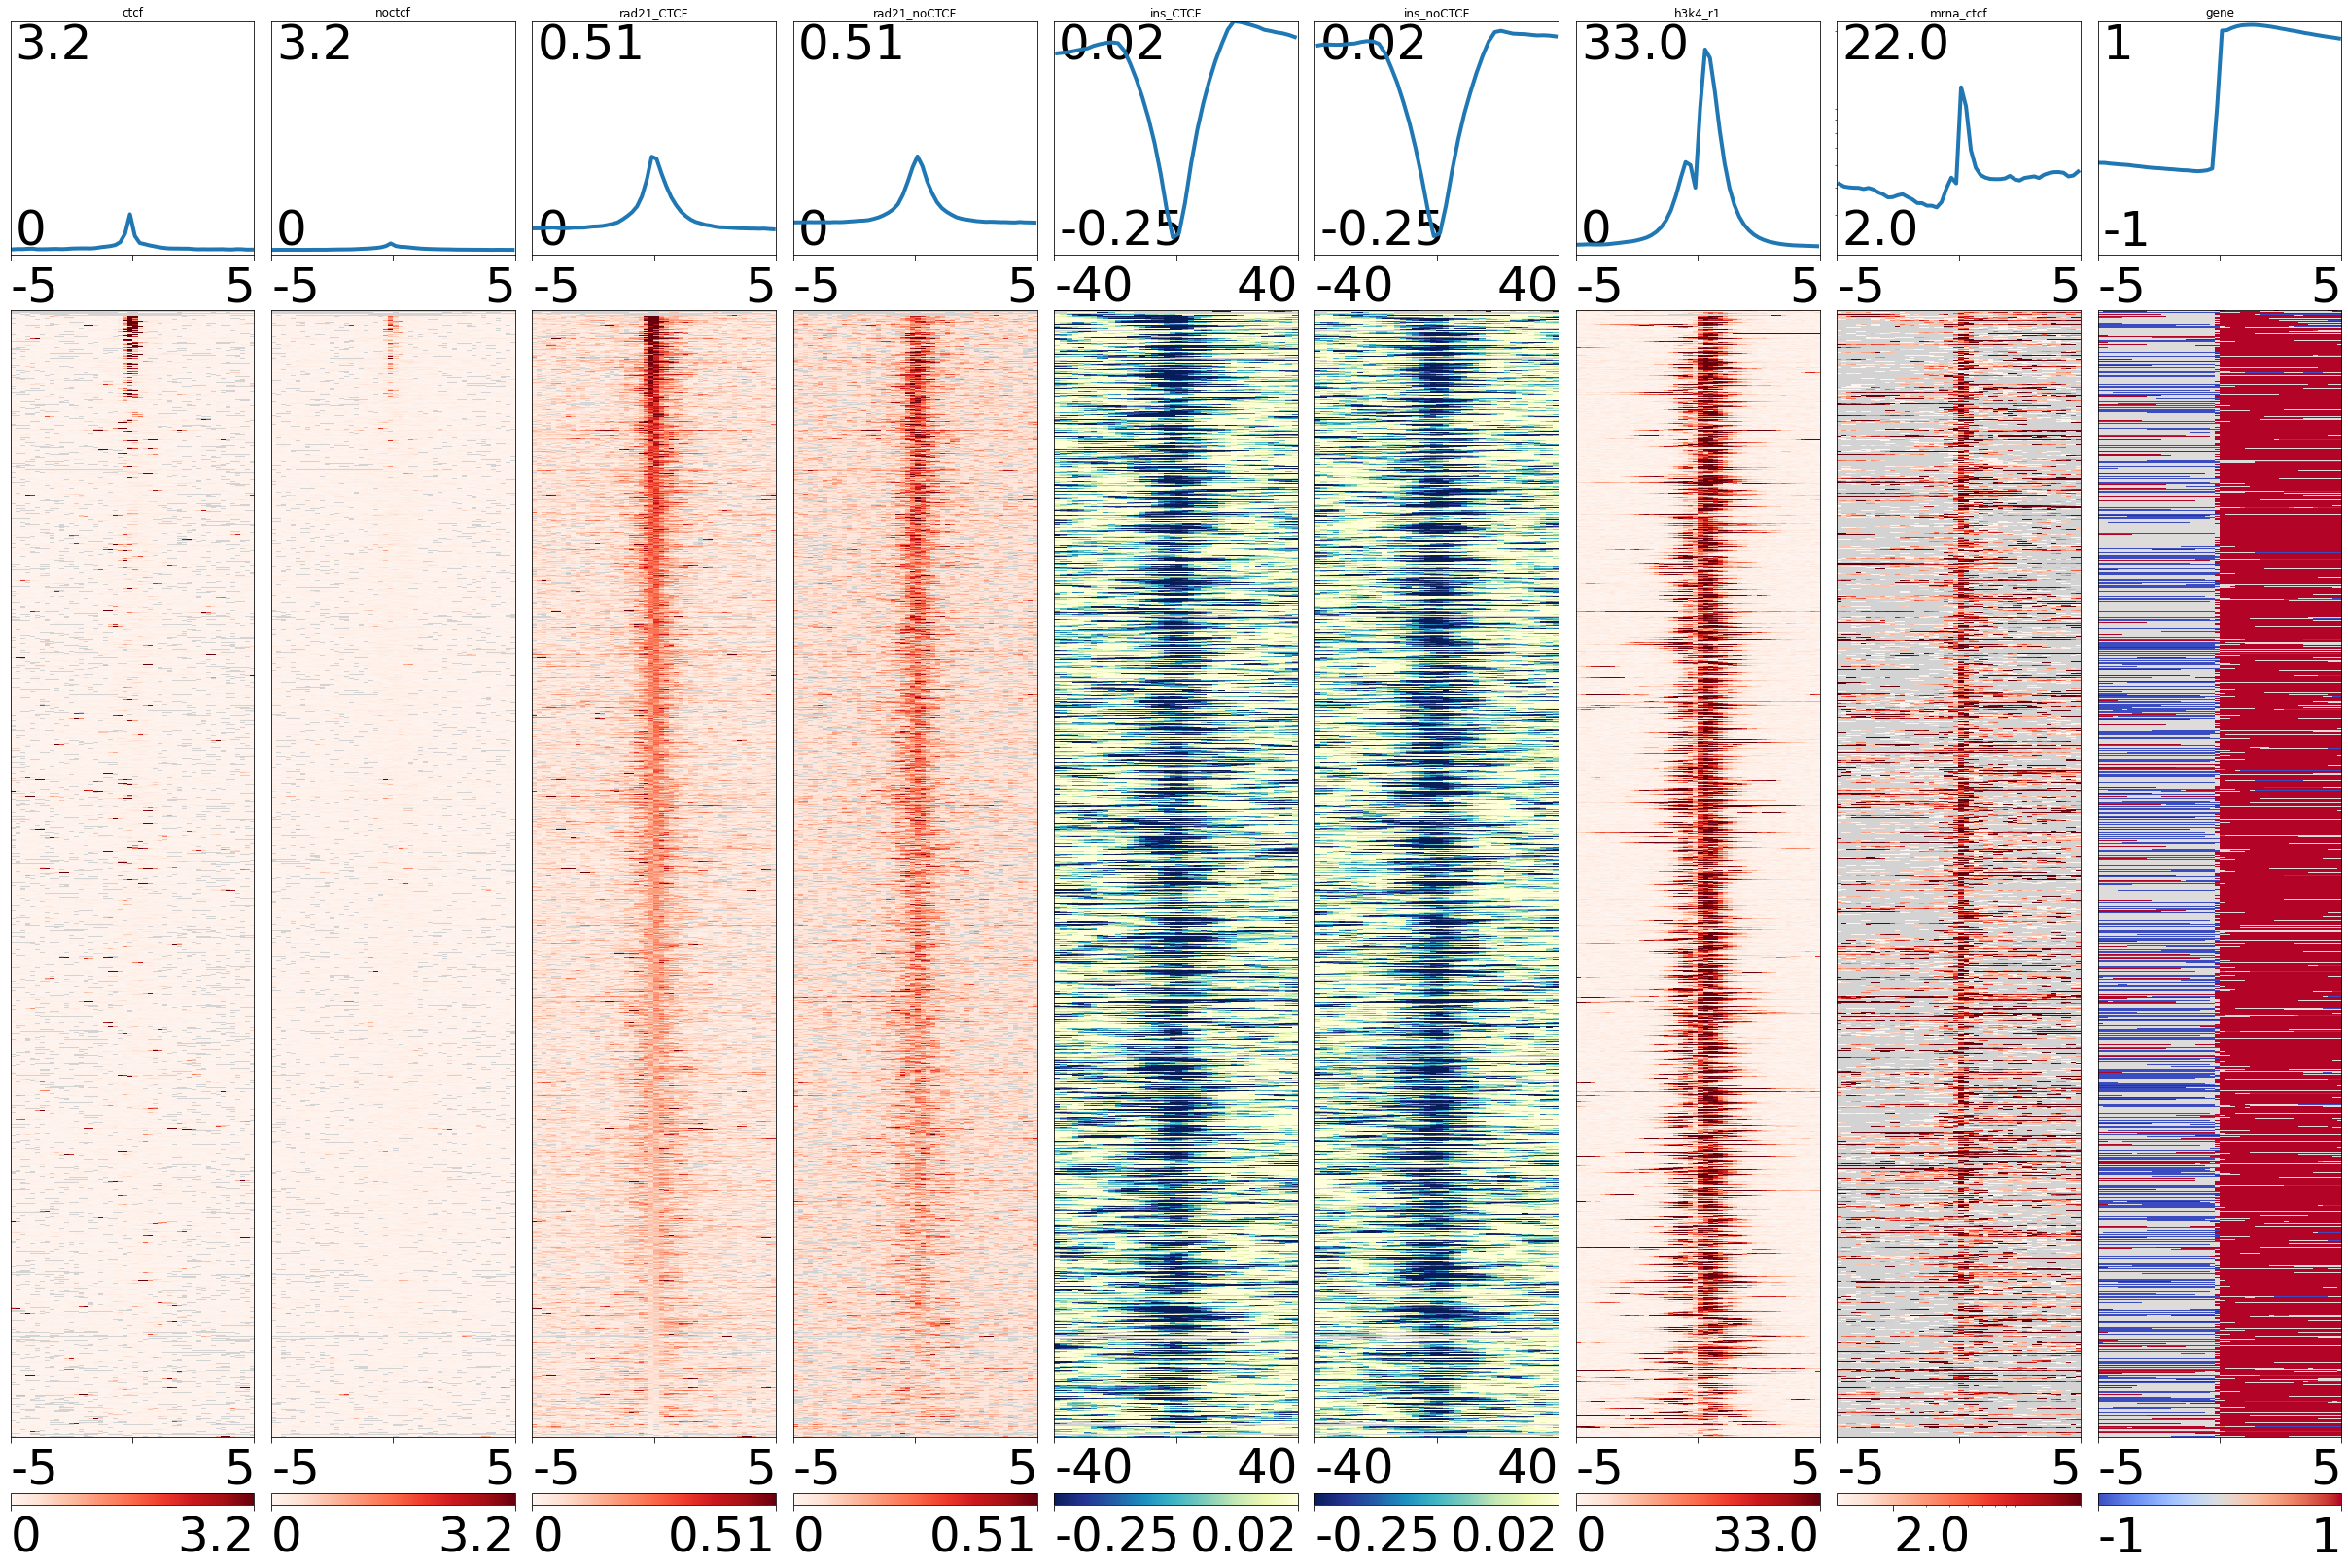

In [17]:
hmss = OrderedDict()
for feature_key in flip_stackup_dict:
    jjj = reordered_jdxs[feature_key]
    _stackups = flip_stackup_dict[feature_key]
    #
    # let's take ative TSS (according to H3K4) only ...
    iii = jjj[:number_of_active_TSS]
    _l, _w = _stackups['rad21_CTCF'].shape
    _cent = int(_w/2)
    tmp_dict = {}
    tmp_dict['rad21_mean'] = np.nanmean(_stackups['rad21_CTCF'][iii,_cent-1:_cent+1],axis=1)

    ks = [('rad21_mean', "sort", 1, False)]
    _, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)
    #
    hmss[feature_key] = [ _stackups[_k][iii[iii_reord]] for _k in supfig1L_samples ]

_limss = [ limss[_k] for _k in supfig1L_samples ]
_cmps = [ cmps[_k] for _k in supfig1L_samples ]
_binsizes = [ binsizes[_k] for _k in supfig1L_samples ]
_norms = [ norms[_k] for _k in supfig1L_samples ]

extra_order = None
hmss_order = None#[0,1,2,3,4,5,6,9,8,10,11,12,7]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

plt.savefig("ActiveTSS_HAP1-RAD21sorted-November.pdf")

In [18]:
!scp ActiveTSS_HAP1-RAD21sorted-November.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !ssh ghpcc rm /nl/umw_job_dekker/users/sv49w/ALV2021/ActiveTSS_HAP1-G4sorted.pdf

ActiveTSS_HAP1-RAD21sorted-November.pdf       100% 1213KB   9.1MB/s   00:00    


## Haven't updated for revision yet ...

### Creating a list of active TSSs - regardless of CTCF (preserve strand info !)

In [35]:
# save list of Acxtive TSSs :
feature_key = "rad_ctcf_union"
jjj = reordered_jdxs[feature_key]
ddf = dfs[feature_key].loc[jjj[:number_of_active_TSS]].reset_index(drop=True)
fname = f"ActiveTSS-{number_of_active_TSS}-1bp.bed"
ddf.to_csv(fname,index=False,header=None,sep="\t")
print(f"Active TSS are saved to {fname} ...")

Active TSS are saved to ActiveTSS-13412-1bp-XXX.bed ...


### Creating a list of active TSSs without CTCF around it ...

In [45]:
from copy import copy

In [46]:
ctcf_df = bioframe.read_table(
    "NT-CTCF-narrowPeaks-sort-merge", # just our NT CTCF ChipSeq peaks ...
    names=["chrom","start","end"]
)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ ctcf_df["chrom"].isin(autosomal_chroms) ]
ctcf_df = ctcf_df.reset_index(drop=True)

In [47]:
# using existing list of active TSSs - we expand them by 2kb on each side ... -> ddf_exp
ddf = ddf.sort_values(["chrom","start"])
_ddf = copy(ddf.reset_index(drop=True))
ddf_exp = bioframe.expand(_ddf,pad=2_000)

In [53]:
# then overlap expanded TSS with CTCF -peaks, to find TSS without CTCF nearby ...
ddf_exp_ctcf = bioframe.overlap(ddf_exp,ctcf_df,how="left",suffixes=('','_')) # keep all TSS
 # peek those, without CTCF 
_mask_TSS_without_CTCF = pd.isnull( ddf_exp_ctcf["chrom_"] )
ddf_exp_noctcf = ddf_exp_ctcf[_mask_TSS_without_CTCF][["chrom","start","end","strand"]]
ddf_exp_noctcf = ddf_exp_noctcf.astype({"start":int,"end":int})
# there shouldn't be any duplicates, but just in case ...
ddf_exp_noctcf = ddf_exp_noctcf.drop_duplicates().reset_index(drop=True)
print(len(ddf_exp_noctcf))

# now let's undo "expand" in a an easiest way - expand with a negative pad = -2000 ...
ddf_exp_noctcf = bioframe.expand(ddf_exp_noctcf, pad=-2_000)
# make footprints are unique ! - all has to be 1 bp!
(ddf_exp_noctcf["end"]-ddf_exp_noctcf["start"]).value_counts()
# save it ...
fname = f"ActiveTSS-NO-CTCF-{len(ddf_exp_noctcf)}-1bp.bed"
ddf_exp_noctcf.to_csv(fname, index=False, header=None, sep="\t")
print(f"saving Active TSS without CTCF nearby to {fname}")

8849
saving Active TSS without CTCF nearby to ActiveTSS-NO-CTCF-8849-1bp.bed
